In [1]:
import os
import numpy as np
from pandas import read_csv
from tqdm import tqdm

## Section 1: Primary Analysis

#### 1.1 Load and prepare data

In [2]:
## Load behavioral correlates.
data = read_csv(os.path.join('data','correlates.csv'))

## Load total scores.
scores = read_csv(os.path.join('data','scores.csv'))

## Load rejection metrics.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Merge DataFrames.
data = data.merge(scores).merge(metrics[['platform','subject','infreq']])

## Re-format infrequency.
data['infreq'] = np.where(data['infreq'] > 0, 0, 1)

#### 1.2 Bootstrap Analysis

In [3]:
from scipy.stats import spearmanr

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define variables.
pairs = [
    ('7d','kappa'),
    ('shaps','kappa')
]

## Define bootstrap parameters.
percentiles = np.linspace(0,0.2,9)
n_bootstrap = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Define indices.
pass_ix, = np.where(data.infreq)
fail_ix, = np.where(1-data.infreq)

## Compute fraction of careless respondents to include.
include = (percentiles * (data.shape[0])).astype(int)

## Preallocate space.
corr = np.zeros((n_bootstrap, percentiles.size, len(pairs)))
pval = np.zeros_like(corr)

for i in tqdm(range(n_bootstrap)):

    for j, n in enumerate(include):
    
        ## Bootstrap participants.
        ix = np.concatenate([pass_ix, np.random.choice(fail_ix, n, replace=True)])
        
        ## Iteratively compute correlations.
        for k, (x, y) in enumerate(pairs):
            
            corr[i,j,k], pval[i,j,k] = spearmanr(data.loc[ix,x], data.loc[ix,y])

100%|██████████| 1000/1000 [00:44<00:00, 22.38it/s]


## Section 2: Plotting

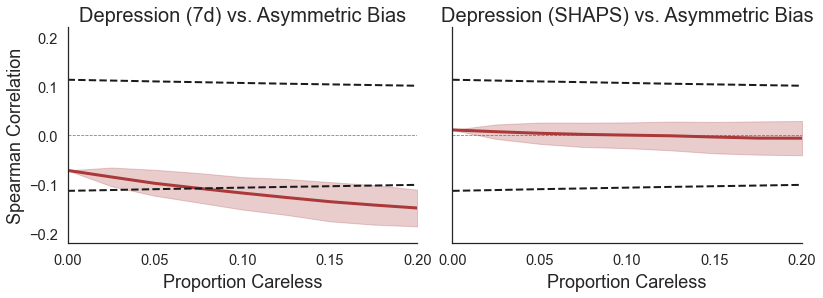

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define canvas.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)

## Define reference values.
critical_values = 1.96 / np.sqrt(include + pass_ix.size - 1)
    
## Define aesthetics.
titles = ['Depression (7d) vs. Asymmetric Bias','Depression (SHAPS) vs. Asymmetric Bias']
bounds = [5, 95]

for i, ax in enumerate(axes):

    ## Calculate bootstrap upper/lower bounds.
    lb = np.apply_along_axis(np.percentile, 0, corr[...,i], bounds[0])
    ub = np.apply_along_axis(np.percentile, 0, corr[...,i], bounds[1])

    ## Plot correlations.
    ax.plot(percentiles, corr[...,i].mean(axis=0), lw=3, color='#AA3939')
    ax.fill_between(percentiles, lb, ub, color='#AA3939', alpha=0.25)
    
    ## Plot critical values.
    ax.plot(percentiles, critical_values, color='k', lw=2, linestyle='--')
    ax.plot(percentiles, -critical_values, color='k', lw=2, linestyle='--')
    ax.axhline(0, color='0.5', lw=0.8, linestyle='--', zorder=-1)
        
    ## Add detail.
    ax.set(xlim=(0.0,0.2), xticks=np.linspace(0,0.2,5), ylim=(-0.22,0.22))
    if not i: ax.set_ylabel('Spearman Correlation', fontsize=18)
    ax.set_xlabel('Proportion Careless', fontsize=18, labelpad=6)
    ax.set_title(titles[i], fontsize=20)

sns.despine()
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15, wspace=0.1)
plt.savefig(os.path.join('..','figures','main_03b.png'), dpi=180, transparent=True)